In [5]:
from PIL import Image
import random


In [6]:
def to_list_without_transp(im):
    px = im.load()
    w,h = im.size
    l = []
    if len(px[0,0]) == 4:
        for i in range(w):
            for j in range(h):
                l.append(px[i,j][:-1])
    else :
        for i in range(w):
            for j in range(h):
                l.append(px[i,j])
    return l

def sort_list(l):
    li = list(set(l))
    lr = []
    for i in li:
        lr.append([i,l.count(i)])
    return sorted(lr, key=lambda x: x[1], reverse=True)

def aff_palette(p):
    im_p = Image.new('RGB', [400,50])
    px_p = im_p.load()

    t = int(400/len(p))

    for index in range(0,len(p)):
        for j in range(t):
            for i in range(50):
                px_p[index*t + j, i] = p[index]
    return im_p

def distance(a,b):
    d = 0
    for i in range(3):
        d = d + (a[i]-b[i])**2
    return d

def pp_couleur(c,p):
    pp_c = p[0]
    for color in p:
        if distance(color, c) <= distance(c,pp_c):
            pp_c = color
    return(pp_c)


def recolor(im, p):
    px = im.load()
    w,h = im.size
    imr = Image.new('RGB', (w,h))
    pxr = imr.load()
    for i in range(w):
        for j in range(h):
            pxr[i,j] = pp_couleur(px[i,j][0:3], p)[0], pp_couleur(px[i,j][0:3], p)[1], pp_couleur(px[i,j][0:3], p)[2]
    return imr

def soustraction(a,b):
    return (a[0]-b[0],a[1]-b[1],a[2]-b[2])

def score(im, im2):
    if im.size == im2.size : 
        s = 0
        px = im.load()
        px2 = im2.load()
        w,h = im.size
        for i in range(w):
            for j in range(h):
                a = soustraction(px[i,j][:3],px2[i,j][:3])
                s += distance(a,(0,0,0))/(w*h*distance((255,255,255),(0,0,0)))
        return 1-s**(1/2)
    else : print("Dimensions différentes")

def set_palette(n,l):
    p = []
    for i in range(n):
        p.append(l[i][0])
    return p 


def first_quantize(path, nb_couleurs_palette) -> Image:
    im = Image.open(path)
    l = to_list_without_transp(im)
    l = sort_list(l)
    palette = set_palette(nb_couleurs_palette,l)
    return recolor(im,palette)

def first_quantize_no_sorting(path, list, nb_couleurs_palette) -> Image:
    im = Image.open(path)
    palette = set_palette(nb_couleurs_palette,list)
    return recolor(im,palette)

def set_rand_palette(im,l, nb_couleur_palette):
    palette = []
    i = random.randint(0,len(l)-1)
    w,h = im.size
    while len(palette) < nb_couleur_palette and i <= w*h:
        i = random.randint(0,len(l)-1)
        if l[i][1]/(w*h) >= 10/(w*h):
            palette.append(l[i][0])
        else:
            palette = palette
    return palette

def random_quantize(path, list, nb_couleurs_palette) -> Image:
    im = Image.open(path)
    palette = set_rand_palette(im,list,nb_couleurs_palette)
    return recolor(im,palette)

# 1. Quantification de couleur première méthode : 

Nous souhaitons réaliser la quantificaion de couleur d'une image.  C'est à dire réduire le nombre de couleurs présentes dans une images à un nombre restreint de couleurs.

La difficulté de cette opération est de choisir les couleurs adéquates pour minimiser la perte en "colorimétrie" sous la contrainte du nombre de couleurs. Perte qui sera évaluer par un score que nous définirons.

Notre première méthode de quantification s'éffectue en trois étapes : 
<ul>
<li> 1.1. Lister des couleurs </li>
<li> 1.2. Définir une palette de couleur pour la quantification </li>
<li> 1.3. Traitement de l'image </li>
</ul>

### 1.1 Lister des couleurs 
Dans un premier temps on liste les couleurs en prenant soin de répertorier leur fréquence d'apparition dans l'image.

La fonction <code> to_list_without_transp </code> réalise parcours l'image et liste les couleurs de chaque pixel.

La fonction <code>sort_list</code> trie la liste en fonction de la fréquence d'apparition


<b>Exemple :</b> 

In [7]:
im = Image.open("beatles.jpeg")
l = to_list_without_transp(im)
l = sort_list(l)
print("La liste après traitement et tri : (les 5 premiers éléments)", l[:5])

La liste après traitement et tri : (les 5 premiers éléments) [[(18, 18, 18), 1180], [(19, 19, 19), 734], [(17, 17, 17), 661], [(21, 21, 21), 638], [(174, 220, 246), 578]]


### 1.2 Définir une palette de couleur pour la quantification

Dans un deuxième temps nous réalisons un choix des couleurs qui reconstitueront l'image. Le choix des couleurs de la palettre se faire par nombre d'apparition: on prend les n couleurs le plus présentes dans l'image, c'est à dire les n premières couleurs de la liste <code>l</code>

Pour cela nous utilisons la fonction <code>set_palette</code> qui renvoie simplement les <code>nb_couleurs_palette</code> premières couleurs de la liste <code>l</code>

In [8]:
nb_couleurs_palette = 8 # Nombre de couleurs que l'ont souhaite avoir dans la palette
palette = set_palette(nb_couleurs_palette,l)
print("Voici les ", nb_couleurs_palette, "premières couleurs qui constituerons notre palette :")
print(palette)

Voici les  8 premières couleurs qui constituerons notre palette :
[(18, 18, 18), (19, 19, 19), (17, 17, 17), (21, 21, 21), (174, 220, 246), (20, 20, 20), (174, 220, 244), (22, 22, 22)]


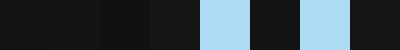

In [9]:
aff_palette(palette)


Nous voyons ici avec l'image des <b>Beatles</b> que notre choix de couleurs n'est pas le optimal en effet, notre image est composée en grande partie de noirs, donc les couleurs les plus fréquentes sont des nuances de noir difficilements différentiables.

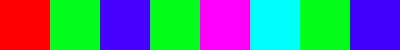

In [10]:
im2 = Image.open("rainbow.png")
l2 = to_list_without_transp(im2)
l2 = sort_list(l2)
palette2 = set_palette(nb_couleurs_palette,l2)
aff_palette(palette2)

### 1.3 Traitement de l'image

Dès lors que nous disposons d'une palette de couleur, il nous suffit de parcourir tout les pixels de l'image et pour chacun des pixels :
<ul> 
    <li>Determiner quelle couleur de la palette est la plus proche de la couleur du pixel (au sens de la norme euclidienen)</li>
    <li>Remplacer la couleur du pixel pour la couleur en question</li>
</ul>

Pour ceci on utilise la fonction <code>first_quantize</code>

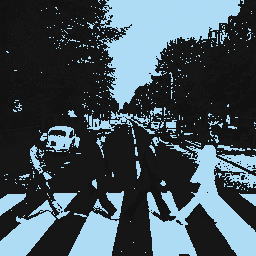

In [11]:
first_quantize("beatles.jpeg", nb_couleurs_palette)

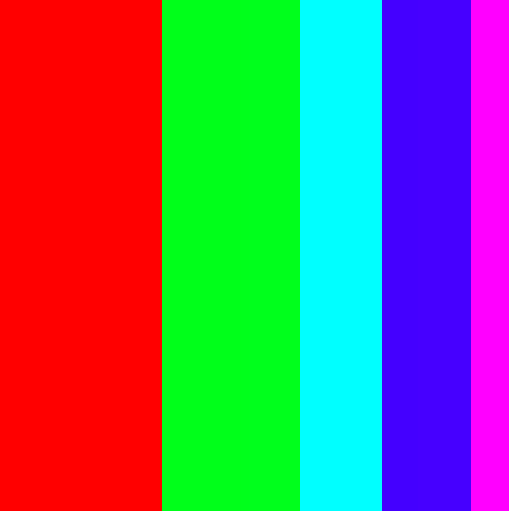

In [16]:
first_quantize("rainbow.png", nb_couleurs_palette)


### 1.4 Performances

Pour évaluer la performance de notre algorithme nous allons faire la moyenne de la norme au carré de la différence de la couleur de chaque pixel (et normalisée pour avoir une valeur comprise entre 0 et 1).entre les deux images. 

$\begin{equation}
 S(I, I_r) = 1 - \sqrt{\frac{\sum_{(i,j) \in [0,w]\times[0,h] }^{w*h-1} \lVert p_{i,j} - pr_{i,j} \lVert^2_2}{w*h* \lVert (255,255,255) \lVert^2}}
\end{equation}
$


Cette évulation est réalisée par la foncion <code>score</code>. Par exemple notre image des <b>Beatles</b> optien un score de : $0.846$

In [43]:
score(im, im_reocolored)

0.824660896154261

Étudions maintenant l'évolution de notre score en fonction du nombre de couleurs dans la palette :

Pour réduire le temps de calcul nous utiliserons la fonction <code>first_quantize_no_sorting</code> qui ne trie pas la liste <code>l</code> mais la prend en argument, car le tri de la liste <code>l</code> est assez long.

In [22]:
l_score = []
for i in range(1,50):
    l_score.append(score(first_quantize_no_sorting("beatles.jpeg",l,i), Image.open("beatles.jpeg")))


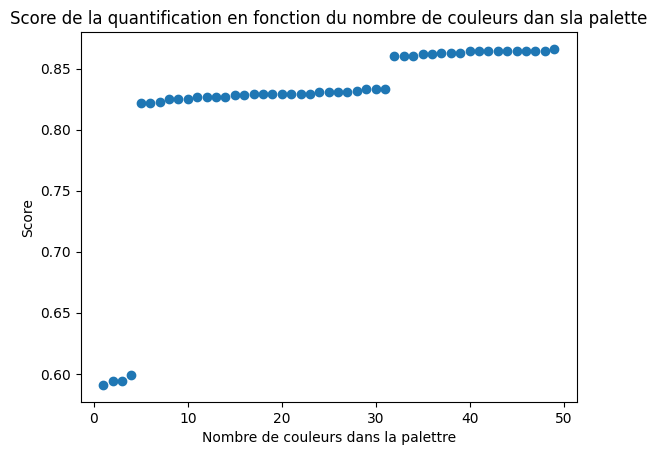

In [23]:
import matplotlib.pyplot as plt
plt.scatter(range(1,50),l_score)
plt.xlabel("Nombre de couleurs dans la palettre")
plt.ylabel("Score")
plt.title("Score de la quantification en fonction du nombre de couleurs dan sla palette")
plt.show()

On remarque ici une augmentation importante et soudaine du score entre 4 et 5 couleurs. Cette discontinuité s'explique par le choix des couleurs dans la palettes, en effet en fonction des images, nous somme amené à determiner une liste de couleurs triées par fréquence d'apparition dont les premières couleurs sont proches. Ainsi on pourrait choisir les <code>nb_couleurs_palette</code> de sortes qu'elles soient deux à deux distantes d'une valeur minimale.

Ce phénomène s'observe très bien avec une image de La Joconde:


Avant : 


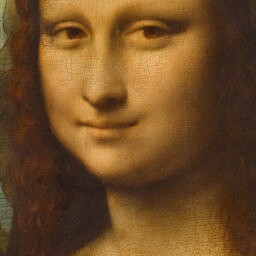

In [19]:
print("Avant : ")
Image.open("j.jpeg")

Après : 


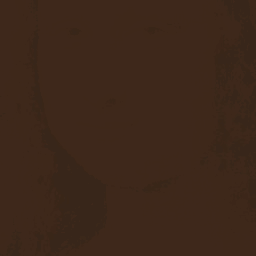

In [20]:
print("Après : ")
first_quantize("j.jpeg", nb_couleurs_palette)

# 2. Deuxième approche, la méthode aléatoire
Le choix de nos couleurs dans la palette n'est pas satisefaisant, étudions le cas d'un choix aléatoire de couleurs. Nous verrons dans cette partie que même si la méthode aléatoire optient <b>en moyenne</b> un meilleur score que notre première méthode, elle est également un choix à exclure.

Pour améliorer les performances de notre quantification, notre choix aléatoire de couleurs se fera sur un panel restreint aux couleurs ayant une fréquence d'apparition signigicative et fixée arbitrairement à :    jeziaheizhai


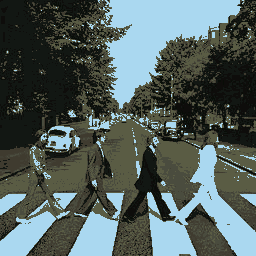

In [53]:
im_rd = random_quantize("beatles.jpeg", l, nb_couleurs_palette) #quantification via un choix aléatoire de couleur
im_rd

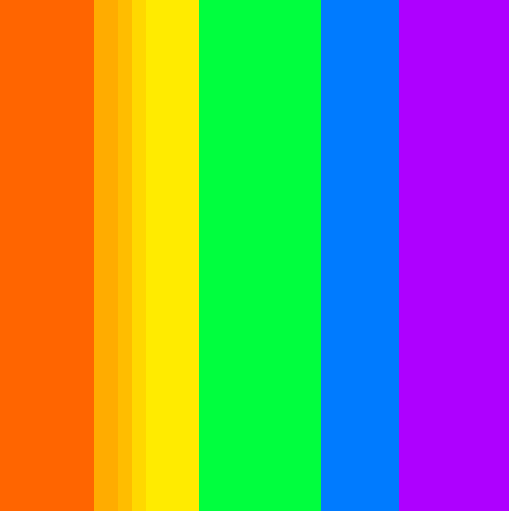

In [23]:
im2_rd =random_quantize("rainbow.png", l2, nb_couleurs_palette)
im2_rd


### Deuxième approche, méthode aléatoire : a

In [59]:
print("Scores")
print(f"Beatles : {score(im_rd,im)}")
print(f"Rainbow : {score(im2_rd,im2)}")

Scores
Beatles : 0.9057176431365128
Rainbow : 0.8086761594516065


### Évolution du score de la méthode random en fonction du nombre du nombre de couleurs dans la palette :

In [28]:
scorebeatles = []
for i  in range(50) :
    scorebeatles.append(score(second_quantize_random("beatles.jpeg", l, nb_couleurs_palette),Image.open("beatles.jpeg")))

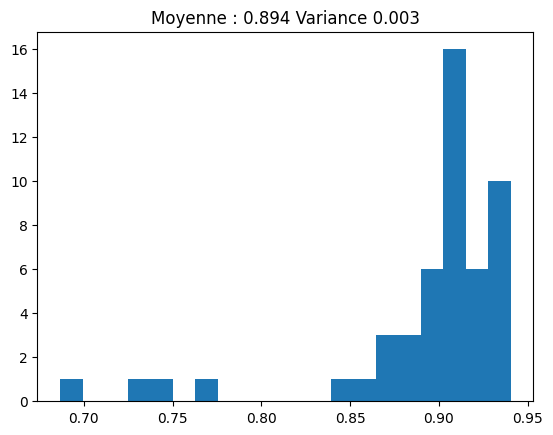

In [29]:
import statistics
plt.hist(scorebeatles, bins = 20)
plt.title(f"Moyenne : {round(statistics.mean(scorebeatles),3)} Variance {round(statistics.variance(scorebeatles),3)}")
plt.show()

In [30]:
lj = to_list_without_transp(Image.open("lp.jpeg"))
lj = sort_list(lj)
second_quantize_random("lp.jpeg", lj, nb_couleurs_palette).show()

In [31]:
score(second_quantize_random("lp.jpeg", lj, nb_couleurs_palette), Image.open("lp.jpeg"))

0.9129241555146027

<b> Finalement la première méthode permet de toujours optenir le même résultat. La méthode aléatoire est plus performante mais n'optient pas le même résultat à chaque fois que le traitement d'image est appliqué. C'est pourquoi il est nécessaire de trouver une autre méthode. </b>